### project 과정
- unigram
- bpe
- mecab

- 조건:
   - 동일한 모델 구조
   - unigram, bpe 동일한 Train, validation, test 구성
   - 동일한 optimizer, 학습률, 하이퍼 파라미터로 설정

- 문제점:
  - mecab(형태소 기반 토큰화):   
      vocab 사이즈를 8000으로 설정했을 때 문법에 맞게 vocab이 이루어지는 장점이 있으나  
      신조어(OOV)에 취약하다는 장점을 가지고 있다.
- 해결 방법:
  - subword 방식이 sentencepiece방식을 사용해서 문장을 더 작게 분리하는 방식으로 해결하고자 함
  - BPE (Byte Pair Encoding): 데이터에 가장 자주 등장하는 글자 쌍을 순차적으로 합쳐(Merge) 나가는 상향식(Bottom-up)  
  서브워드 분절 방식입니다.

  - Unigram: 가능한 모든 서브워드 후보에서 시작해, 문장 생성 확률(우도)을 가장 높이는 토큰만 남기고 나머지는 제거(Pruning)  
    하는 하향식(Top-down) 방식입니다.

### 회고: 
텍스트 데이터를 다루는 방법이 어려운 것은 알고 있었는데 전처리 방식외에도 다양한 방법으로 텍스트 데이터를 다루는 방법을 알게 되어 좋은 경험이었던 거 같습니다.
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import sentencepiece as spm
import os
import copy

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current Device: {device}")

Current Device: cuda


In [2]:
# file path
path_to_file = "korean-english-park.train.ko"
temp_file = 'korean-english-park.train.ko.temp'

---

In [3]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


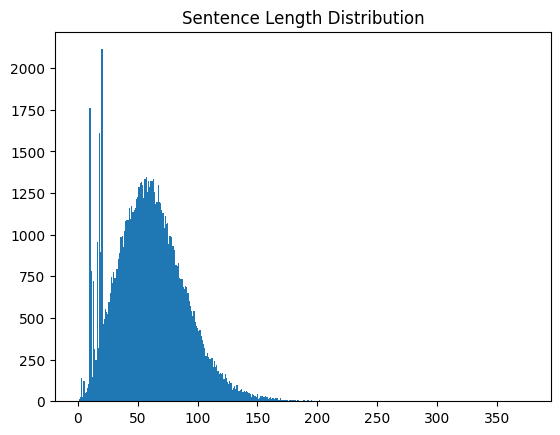

In [4]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [5]:
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)


’


In [6]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [7]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


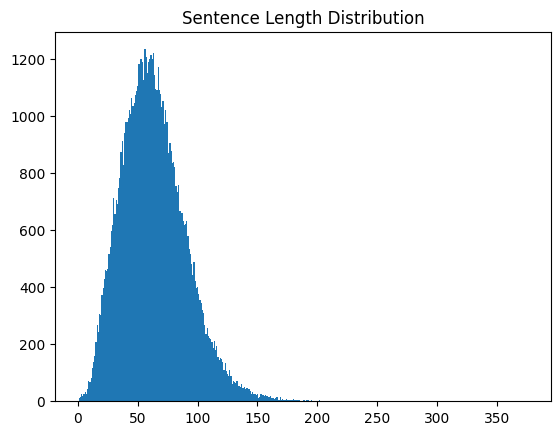

In [8]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

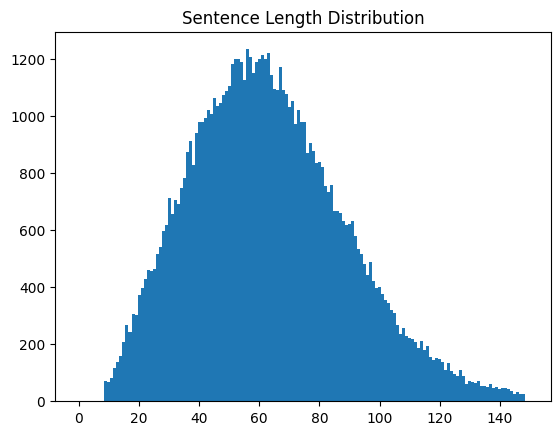

In [9]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

---

In [10]:
# 하이퍼파라미터
vocab_size = 8000
BATCH_SIZE = 128
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
N_LAYERS = 2
DROPOUT = 0.3
PAD_IDX = 0
LEARNING_RATE = 1e-3
EPOCHS = 10  # 필요에 따라 조절
loss_fn = nn.BCEWithLogitsLoss()

In [11]:
def sp_tokenize(s, corpus):
    tensor = []
    for sen in corpus:
        ids = s.EncodeAsIds(str(sen))
        tensor.append(torch.LongTensor(ids))
    # Padding (0으로 채움)
    tensor = pad_sequence(tensor, batch_first=True, padding_value=0)
    return tensor


In [12]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, hidden_size=64, num_layers=2, dropout_rate=0.5, pad_idx=0):
        super(SentimentModel, self).__init__()
        
        # 1. 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=pad_idx)
        
        # 2. 양방향 LSTM (Bidirectional=True)
        self.lstm = nn.LSTM(word_vector_dim, 
                            hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            bidirectional=True, 
                            dropout=0.3 if num_layers > 1 else 0)
        
        # 3. 정규화 및 드롭아웃
        self.ln = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_rate)

        # 4. 분류기 (Classifier)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        
        # 0이 아닌 실제 길이 계산
        lengths = (x != 0).sum(dim=1).cpu()
        lengths = torch.clamp(lengths, min=1) # 길이 0 방지

        # 1. 임베딩
        x = self.embedding(x)
        x = self.dropout(x)
        
        # 2. Pack Padded Sequence (패딩 무시하고 실제 데이터만 LSTM에 입력)
        packed_input = rnn_utils.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        
        # 3. LSTM 통과
        # output: 전체 시퀀스의 출력 (PackedSequence 형태)
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # 4. 마지막 Hidden State 추출 (양방향 처리)
        cat_hn = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)
        
        # 5. Layer Norm & Dropout
        x = self.ln(cat_hn)
        x = self.dropout(x)
        
        # 6. Dense Layers (FC)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

In [13]:
def validation(val_loader, model, loss_fn, device):
    model.eval()

    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 출력
            outputs = model(inputs).squeeze()
            
            # Batch Size가 1일 경우 차원이 아예 사라지는 것(Scalar) 방지
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            
            # [수정됨] labels.float() 뒤에 .view(-1) 추가
            loss = loss_fn(outputs, labels.float().view(-1)) 
            val_loss += loss.item()

            # 확률값 및 예측값 계산
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # [수정됨] 정확도 계산 시에도 shape 일치 (.view(-1) 추가)
            val_correct += (preds == labels.view(-1)).sum().item()
            val_total += labels.size(0)

    avg_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    return avg_loss, val_acc

In [14]:
def train(train_loader, val_loader, model, device, loss_fn, lr=5e-4, epochs = 30, patience=15):
    optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay=1e-4)

    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)

    history = {
        'train_loss': [], 'train_acc': [], 'lr_history': [],
        'val_loss': [], 'val_acc': []
    }

    # 조기 종료를 위한 변수 초기화
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs).squeeze()

            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            # Squeeze를 통한 차원 맞춤 및 손실 계산
            loss = loss_fn(outputs, labels.float().view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            correct += (preds == labels.view(-1)).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc= validation(val_loader, model, loss_fn, device)

        # 기록 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {history['train_loss'][-1]:.4f}, Train Accuracy: {history['train_acc'][-1]:.4f} - "
          f"Validation Loss: {history['val_loss'][-1]:.4f}, Validation Accuracy: {history['val_acc'][-1]:.4f}")

        # scheduler.step(val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        history['lr_history'].append(current_lr)

        # 조기 종료 및 모델 저장 로직
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) 
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    # 최적의 상태로 모델 복구
    model.load_state_dict(best_model_wts)
    return history 

In [15]:
def predict_and_show_table(model, loader, tokenizer, device, num_samples=10):
    """
    Test Loader에서 데이터를 가져와 모델 예측을 수행하고,
    입력된 num_samples 개수만큼의 결과를 테이블(DataFrame)로 보여주는 함수.
    """
    model.eval()
    results = []
    count = 0
    
    with torch.no_grad():
        for batch in loader:
            text, label = batch
            text = text.to(device)
            label = label.to(device)
            
            # 예측 수행
            logits = model(text)
            probs = torch.sigmoid(logits)  # 확률로 변환 (0~1)
            preds = torch.round(probs)     # 0 또는 1로 변환
            
            # 배치 내의 각 데이터 처리
            for i in range(len(text)):
                if count >= num_samples:
                    break
                
                # 1. 입력 텍스트 복원 (ID -> Text)
                # Pad ID(0)는 제외하고 디코딩
                input_ids = text[i].cpu().tolist()
                decoded_text = tokenizer.DecodeIds([tid for tid in input_ids if tid != 0])
                
                # 2. 정답 및 예측값
                actual = int(label[i].item())
                predicted = int(preds[i].item())
                probability = probs[i].item()
                
                # 3. 결과 저장
                results.append({
                    "Input Text": decoded_text,
                    "Actual Label": "Positive" if actual == 1 else "Negative",
                    "Predicted Label": "Positive" if predicted == 1 else "Negative",
                    "Probability": f"{probability:.4f}",
                    "Correct": "O" if actual == predicted else "X"
                })
                count += 1
            
            if count >= num_samples:
                break
    
    # DataFrame 생성 및 출력
    df_results = pd.DataFrame(results)
    print(f"\\n>>> Prediction Examples (Top {num_samples}) <<<")
    display(df_results) # Jupyter Notebook 환경에서 테이블 출력

In [16]:
# 데이터 로드
train_df = pd.read_table('ratings_train.txt').dropna(subset=['document'])
test_df = pd.read_table('ratings_test.txt').dropna(subset=['document'])

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Total Train Data: {len(train_df)}")
print(f"Split -> Train: {len(train_df)}, Valid: {len(valid_df)}")
print(f"Test Data: {len(test_df)}")

Total Train Data: 119996
Split -> Train: 119996, Valid: 29999
Test Data: 49997


---

In [17]:
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

uni_model_prefix = 'korean_uni'

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={} --model_type=unigram'.format(
        temp_file, uni_model_prefix, vocab_size
    )
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=korean-english-park.train.ko.temp --model_prefix=korean_uni --vocab_size=8000 --model_type=unigram
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_uni
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_voc

In [18]:
sp_uni = spm.SentencePieceProcessor()
sp_uni.Load('korean_uni.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = sp_uni.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(sp_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',-1, 0.1))

# SentencePiece를 활용한 encoding -> sentence 복원
print(sp_uni.DecodeIds(tokensIDs))

[1246, 11, 302, 7, 3541, 11, 287, 33, 4]
['▁', '아버지', '가', '방', '에', '들', '어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [19]:
# Train / Valid / Test 각각 토큰화
x_train = sp_tokenize(sp_uni, train_df['document'])
y_train = torch.tensor(train_df['label'].values, dtype=torch.float32).unsqueeze(1)

x_valid = sp_tokenize(sp_uni, valid_df['document'])
y_valid = torch.tensor(valid_df['label'].values, dtype=torch.float32).unsqueeze(1)

x_test = sp_tokenize(sp_uni, test_df['document'])
y_test = torch.tensor(test_df['label'].values, dtype=torch.float32).unsqueeze(1)

In [20]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
test_ds = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

---

In [21]:
uni_model = SentimentModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT, PAD_IDX).to(device)
print(uni_model)

SentimentModel(
  (embedding): Embedding(8000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [22]:
uni_history = train(train_loader, test_loader, uni_model, device, loss_fn, lr=LEARNING_RATE, epochs=EPOCHS, patience=5)

Epoch 1/10 - Train Loss: 0.5109, Train Accuracy: 0.7443 - Validation Loss: 0.4051, Validation Accuracy: 0.8131
Epoch 2/10 - Train Loss: 0.4153, Train Accuracy: 0.8124 - Validation Loss: 0.3817, Validation Accuracy: 0.8287
Epoch 3/10 - Train Loss: 0.3831, Train Accuracy: 0.8293 - Validation Loss: 0.3688, Validation Accuracy: 0.8374
Epoch 4/10 - Train Loss: 0.3625, Train Accuracy: 0.8397 - Validation Loss: 0.3733, Validation Accuracy: 0.8370
Epoch 5/10 - Train Loss: 0.3473, Train Accuracy: 0.8481 - Validation Loss: 0.3521, Validation Accuracy: 0.8480
Epoch 6/10 - Train Loss: 0.3341, Train Accuracy: 0.8558 - Validation Loss: 0.3516, Validation Accuracy: 0.8475
Epoch 7/10 - Train Loss: 0.3207, Train Accuracy: 0.8624 - Validation Loss: 0.3485, Validation Accuracy: 0.8504
Epoch 8/10 - Train Loss: 0.3118, Train Accuracy: 0.8657 - Validation Loss: 0.3462, Validation Accuracy: 0.8532
Epoch 9/10 - Train Loss: 0.3029, Train Accuracy: 0.8714 - Validation Loss: 0.3472, Validation Accuracy: 0.8509
E

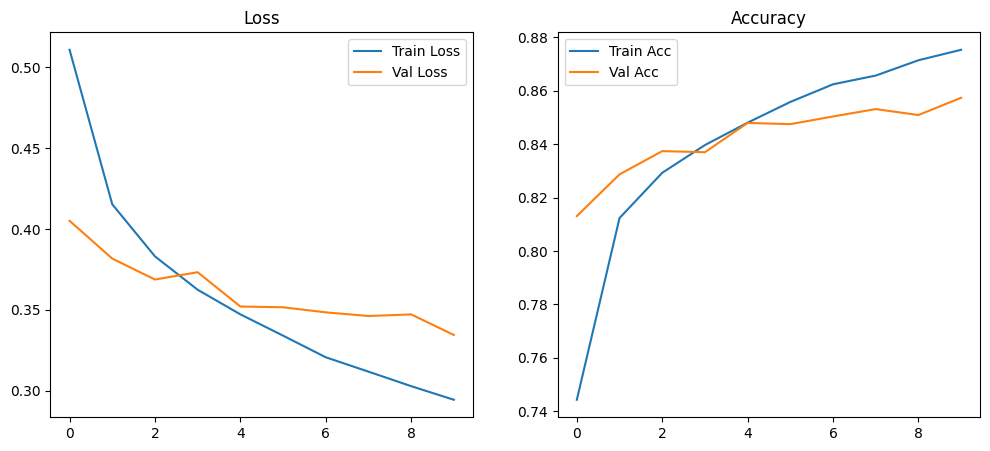

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(uni_history['train_loss'], label='Train Loss')
plt.plot(uni_history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(uni_history['train_acc'], label='Train Acc')
plt.plot(uni_history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [24]:
# --- 함수 실행 (예: 10개 출력) ---
predict_and_show_table(uni_model, test_loader, sp_uni, device, num_samples=10)

\n>>> Prediction Examples (Top 10) <<<


,Input Text,Actual Label,Predicted Label,Probability,Correct
0,굳,Positive,Positive,0.9630,O
1,GDNTOPCLASSINTHECLUB,Negative,Positive,0.7645,X
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니아,Negative,Negative,0.4650,O
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,Negative,Negative,0.0228,O
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,Negative,Negative,0.0049,O
5,"음악이 주가 된, 최고의 음악영화",Positive,Positive,0.9965,O
6,진정한 쓰레기,Negative,Negative,0.0024,O
7,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",Negative,Negative,0.1372,O
8,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,Negative,Negative,0.0010,O
9,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",Positive,Positive,0.7820,O


---

In [25]:
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

bpe_model_prefix = 'korean_bpe'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={} --model_type=bpe'.format(temp_file,  bpe_model_prefix, vocab_size),
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=korean-english-park.train.ko.temp --model_prefix=korean_bpe --vocab_size=8000 --model_type=bpe
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_bpe
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  

In [26]:
sp_bpe = spm.SentencePieceProcessor()
sp_bpe.Load('korean_bpe.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = sp_bpe.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(sp_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',-1, 0.1))

# SentencePiece를 활용한 encoding -> sentence 복원
print(sp_bpe.DecodeIds(tokensIDs))

[1520, 1154, 6615, 6710, 2645, 6782, 6685, 6687]
['▁아버', '지가', '방', '에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


In [27]:
# Train / Valid / Test 각각 토큰화
x_train = sp_tokenize(sp_bpe, train_df['document'])
y_train = torch.tensor(train_df['label'].values, dtype=torch.float32).unsqueeze(1)

x_valid = sp_tokenize(sp_bpe, valid_df['document'])
y_valid = torch.tensor(valid_df['label'].values, dtype=torch.float32).unsqueeze(1)

x_test = sp_tokenize(sp_bpe, test_df['document'])
y_test = torch.tensor(test_df['label'].values, dtype=torch.float32).unsqueeze(1)

In [28]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
test_ds = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
bpe_model = SentimentModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT, PAD_IDX).to(device)
print(bpe_model)

SentimentModel(
  (embedding): Embedding(8000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [30]:
bpe_history = train(train_loader, test_loader, bpe_model, device, loss_fn, lr=LEARNING_RATE, epochs=EPOCHS, patience=5)

Epoch 1/10 - Train Loss: 0.5129, Train Accuracy: 0.7429 - Validation Loss: 0.4165, Validation Accuracy: 0.8078
Epoch 2/10 - Train Loss: 0.4176, Train Accuracy: 0.8108 - Validation Loss: 0.3841, Validation Accuracy: 0.8252
Epoch 3/10 - Train Loss: 0.3878, Train Accuracy: 0.8255 - Validation Loss: 0.3829, Validation Accuracy: 0.8332
Epoch 4/10 - Train Loss: 0.3666, Train Accuracy: 0.8379 - Validation Loss: 0.3720, Validation Accuracy: 0.8396
Epoch 5/10 - Train Loss: 0.3501, Train Accuracy: 0.8465 - Validation Loss: 0.3610, Validation Accuracy: 0.8430
Epoch 6/10 - Train Loss: 0.3369, Train Accuracy: 0.8532 - Validation Loss: 0.3548, Validation Accuracy: 0.8461
Epoch 7/10 - Train Loss: 0.3274, Train Accuracy: 0.8580 - Validation Loss: 0.3739, Validation Accuracy: 0.8487
Epoch 8/10 - Train Loss: 0.3152, Train Accuracy: 0.8649 - Validation Loss: 0.3545, Validation Accuracy: 0.8492
Epoch 9/10 - Train Loss: 0.3067, Train Accuracy: 0.8687 - Validation Loss: 0.3460, Validation Accuracy: 0.8486
E

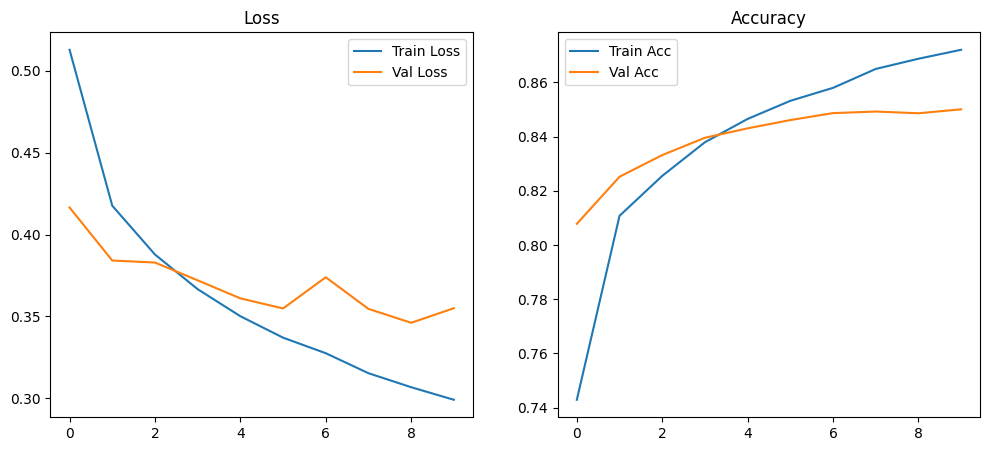

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bpe_history['train_loss'], label='Train Loss')
plt.plot(bpe_history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bpe_history['train_acc'], label='Train Acc')
plt.plot(bpe_history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [32]:
# --- 함수 실행 (예: 10개 출력) ---
predict_and_show_table(bpe_model, test_loader, sp_bpe, device, num_samples=10)

\n>>> Prediction Examples (Top 10) <<<


,Input Text,Actual Label,Predicted Label,Probability,Correct
0,굳,Positive,Positive,0.9439,O
1,GDNTOPCLASSINTHECLUB,Negative,Positive,0.9845,X
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니아,Negative,Negative,0.4339,O
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,Negative,Negative,0.0042,O
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,Negative,Negative,0.0182,O
5,"음악이 주가 된, 최고의 음악영화",Positive,Positive,0.9702,O
6,진정한 쓰레기,Negative,Negative,0.0032,O
7,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",Negative,Negative,0.2576,O
8,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,Negative,Negative,0.0018,O
9,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",Positive,Positive,0.5268,O


---

In [33]:
from konlpy.tag import Mecab
from collections import Counter

In [34]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [35]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_df, test_df, num_words=vocab_size)

In [36]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  16.941410194758355
문장길이 최대 :  117
문장길이 표준편차 :  12.837032681342041
pad_sequences maxlen :  42
전체 문장의 0.9345275306564078%가 maxlen 설정값 이내에 포함됩니다. 


In [37]:
def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

In [38]:
# 텐서/배열 슬라이싱
partial_x_train, x_val, partial_y_train, y_val = train_test_split(
    x_train_tensor, y_train, test_size=0.2, random_state=42
)

print(partial_x_train.shape)
print(partial_y_train.shape)

print(f"Train set: {partial_x_train.shape}, Labels: {partial_y_train.shape}")
print(f"Val set: {x_val.shape}, Labels: {y_val.shape}")

NameError: name 'x_train_tensor' is not defined

In [ ]:
partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

/tmp/ipykernel_99360/1147762616.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_99360/1147762616.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


In [ ]:
Sent_model = SentimentModel(vocab_size, EMBEDDING_DIM).to(device)
print(Sent_model)

SentimentModel(
  (embedding): Embedding(8000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
Sent_history = train(train_loader, val_loader, Sent_model, device, loss_fn, lr=LEARNING_RATE, epochs = 30)

Epoch 1/30 - Train Loss: 0.6940, Train Accuracy: 0.5040 - Validation Loss: 0.6932, Validation Accuracy: 0.4983
Epoch 2/30 - Train Loss: 0.6927, Train Accuracy: 0.5060 - Validation Loss: 0.6878, Validation Accuracy: 0.5147
Epoch 3/30 - Train Loss: 0.6859, Train Accuracy: 0.5243 - Validation Loss: 0.6723, Validation Accuracy: 0.5424
Epoch 4/30 - Train Loss: 0.6738, Train Accuracy: 0.5405 - Validation Loss: 0.6699, Validation Accuracy: 0.5370
Epoch 5/30 - Train Loss: 0.6658, Train Accuracy: 0.5459 - Validation Loss: 0.6596, Validation Accuracy: 0.5440
Epoch 6/30 - Train Loss: 0.6606, Train Accuracy: 0.5500 - Validation Loss: 0.6545, Validation Accuracy: 0.5467
Epoch 7/30 - Train Loss: 0.6562, Train Accuracy: 0.5554 - Validation Loss: 0.6528, Validation Accuracy: 0.5570


In [ ]:
test_loss, test_acc  = validation(test_loader, Sent_model, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.6434, Test Accuracy: 0.5666


In [ ]:
def predict_and_show_table_LSTM(model, loader, index_to_word, device, num_samples=10):
    model.eval()
    results = []
    count = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 1. 모델 예측
            outputs = model(inputs).squeeze()
            if outputs.dim() == 0: outputs = outputs.unsqueeze(0) # 배치 1일 때 안전장치
            
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            # 2. 리스트로 변환
            input_list = inputs.cpu().tolist()
            label_list = labels.cpu().tolist()
            pred_list = preds.cpu().tolist()
            prob_list = probs.cpu().tolist()
            
            for i in range(len(input_list)):
                if count >= num_samples: break
                
                # 3. 텍스트 복원 (숫자 -> 단어)
                decoded_words = []
                for idx in input_list[i]:
                    if idx == 0: 
                        continue
                    word = index_to_word.get(idx, "<UNK>")
                    decoded_words.append(word)
                
                # MeCab은 형태소 단위로 쪼개져 있으므로 공백으로 이어줍니다.
                decoded_text = " ".join(decoded_words)
                
                # 4. 결과 저장
                actual = int(label_list[i])
                predicted = int(pred_list[i])
                
                results.append({
                    "입력 텍스트": decoded_text,
                    "실제 라벨": "긍정(1)" if actual == 1 else "부정(0)",
                    "예측 라벨": "긍정(1)" if predicted == 1 else "부정(0)",
                    "확률": f"{prob_list[i]:.4f}",
                    "정답": "O" if actual == predicted else "X"
                })
                count += 1
                
            if count >= num_samples: break
            
    # 데이터프레임 출력
    df_results = pd.DataFrame(results)
    print(f"\n>>> 모델 예측 결과 예시 (Top {num_samples}) <<<")
    display(df_results)
    
    return df_results

In [ ]:
predict_and_show_table_LSTM(Sent_model, test_loader, index_to_word, device, num_samples=10)